# vLLM Qwen1.5-72B-Chat-AWQ vLLM deployment guide
In this tutorial, you will use LMI container from DLC to SageMaker and run inference with it.

Please make sure the following permission granted before running the notebook:

- S3 bucket push access
- SageMaker access

## Step 1: Let's bump up SageMaker and import stuff

In [6]:
%pip install sagemaker --upgrade  --quiet
%pip install boto3==1.34.101

Note: you may need to restart the kernel to use updated packages.
  Using cached boto3-1.34.101-py3-none-any.whl.metadata (6.6 kB)
Using cached boto3-1.34.101-py3-none-any.whl (139 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 89.4 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.34.51
    Uninstalling botocore-1.34.51:
      Successfully uninstalled botocore-1.34.51
  Attempting uninstall: boto3
    Found existing installation: boto3 1.34.51
    Uninstalling boto3-1.34.51:
      Successfully uninstalled boto3-1.34.51
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.12.1 requires botocore<1.34.52,>=1.34.41, but you have botocore 1.34.113 which is incompatible.
amazon-sagemaker-jupyter-scheduler 3.0.7 requires jupyter-scheduler==2.5, but you have jupyter-scheduler 2.5.1 which is i

In [1]:
import boto3
import sagemaker
from sagemaker import Model, image_uris, serializers, deserializers

role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
region = sess._region_name  # region name of the current SageMaker Studio environment
account_id = sess.account_id()  # account_id of the current SageMaker Studio environment

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Step 2: Start preparing model artifacts
In LMI contianer, we expect some artifacts to help setting up the model
- serving.properties (required): Defines the model server settings
- model.py (optional): A python file to define the core inference logic
- requirements.txt (optional): Any additional pip wheel need to install

In [7]:
%%writefile serving.properties
engine=Python
option.model_id=Qwen/Qwen1.5-32B-Chat
option.task=text-generation
option.trust_remote_code=true
option.tensor_parallel_degree=4
option.rolling_batch=vllm
option.dtype=fp16
option.max_rolling_batch_size=64
option.max_model_len=4096

Writing serving.properties


In [8]:
%%sh
mkdir mymodel
mv serving.properties mymodel/
tar czvf mymodel.tar.gz mymodel/
rm -rf mymodel

mymodel/
mymodel/serving.properties


## Step 3: Start building SageMaker endpoint
In this step, we will build SageMaker endpoint from scratch

### Getting the container image URI

[Large Model Inference available DLC](https://github.com/aws/deep-learning-containers/blob/master/available_images.md#large-model-inference-containers)


In [9]:
image_uri = image_uris.retrieve(
        framework="djl-deepspeed",
        region=sess.boto_session.region_name,
        version="0.27.0"
    )

### Upload artifact on S3 and create SageMaker model

In [10]:
s3_code_prefix = "large-model-lmi/code-qwen1.5-32B"
bucket = sess.default_bucket()  # bucket to house artifacts
code_artifact = sess.upload_data("mymodel.tar.gz", bucket, s3_code_prefix)
print(f"S3 Code or Model tar ball uploaded to --- > {code_artifact}")

model = Model(image_uri=image_uri, model_data=code_artifact, role=role)

S3 Code or Model tar ball uploaded to --- > s3://sagemaker-us-east-1-434444145045/large-model-lmi/code-qwen1.5-32B/mymodel.tar.gz


### 4.2 Create SageMaker endpoint

You need to specify the instance to use and endpoint names

In [11]:
instance_type = "ml.g5.12xlarge"
endpoint_name = sagemaker.utils.name_from_base("lmi-model-qwen1-5-32B")

model.deploy(initial_instance_count=1,
             instance_type=instance_type,
             endpoint_name=endpoint_name,
             # container_startup_health_check_timeout=3600
            )



-------------!

In [12]:
# endpoint_name = 'lmi-model-qwen1-5-72B-2024-05-23-09-10-23-101'
print(endpoint_name)

lmi-model-qwen1-5-32B-2024-05-27-05-58-12-934


In [13]:
# our requests and responses will be in json format so we specify the serializer and the deserializer
predictor = sagemaker.Predictor(
    endpoint_name=endpoint_name,
    sagemaker_session=sess,
    serializer=serializers.JSONSerializer(),
    deserializer=sagemaker.deserializers.JSONDeserializer(),
)

## Step 5: Test and benchmark the inference

In [15]:
!pip install transformers -U

  Using cached transformers-4.41.1-py3-none-any.whl.metadata (43 kB)
  Using cached huggingface_hub-0.23.1-py3-none-any.whl.metadata (12 kB)
  Using cached tokenizers-0.19.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
Using cached transformers-4.41.1-py3-none-any.whl (9.1 MB)
Using cached huggingface_hub-0.23.1-py3-none-any.whl (401 kB)
Using cached tokenizers-0.19.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface_hub 0.22.0
    Uninstalling huggingface_hub-0.22.0:
      Successfully uninstalled huggingface_hub-0.22.0
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.13.3
    Uninstalling tokenizers-0.13.3:
      Successfully uninstalled tokenizers-0.13.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.31.0
    Uninstalling transformers-4.31.0:
      Successfully uninstalled transfor

In [14]:
from transformers import AutoTokenizer

MODEL_DIR = "Qwen/Qwen1.5-32B-Chat"
# model = AutoModelForCausalLM.from_pretrained(MODEL_DIR, torch_dtype="auto")
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR, use_fast=False)

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
prompt = "世界上第二高峰是哪座？"
messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": prompt}
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
parameters = {
        "max_new_tokens":1024, 
        "do_sample": True,
        "stop_token_ids":[151645,151643],
        "repetition_penalty": 1.05,
        "temperature": 0.7,
        "top_p": 0.8,
        "top_k": 20
    }
response = predictor.predict(
    {"inputs": inputs, "parameters": parameters}
)
# text = str(response, "utf-8")
print(response)

{'generated_text': '世界上第二高峰是乔戈里峰（K2），位于巴基斯坦和中国的边界上，海拔8,611米（28,251英尺）。它是世界上最高的未登顶山峰之一，以其严酷的登山条件而闻名。第一位成功登顶乔戈里峰的是意大利登山家雷纳托·卡斯特拉尼奥利和阿根廷登山家莫里斯·赫尔佐格，他们在1954年完成了这项壮举。'}


# Streaming

In [23]:
import json
import boto3

smr_client = boto3.client("sagemaker-runtime")

In [24]:
import io
import json

class TokenIterator:
    def __init__(self, stream):
        self.byte_iterator = iter(stream)
        self.buffer = io.BytesIO()
        self.read_pos = 0

    def __iter__(self):
        return self

    def __next__(self):
        while True:
            self.buffer.seek(self.read_pos)
            line = self.buffer.readline()
            
            # print(line)
            if line and line[-1] == ord("\n"):
                self.read_pos += len(line)
                full_line = line[:-1].decode("utf-8")
                # print(full_line)
                line_data = json.loads(full_line.lstrip("data:").rstrip("/n"))
                return line_data["token"].get("text", "")
            chunk = next(self.byte_iterator)
            self.buffer.seek(0, io.SEEK_END)
            self.buffer.write(chunk["PayloadPart"]["Bytes"])
        
def get_realtime_response_stream(sagemaker_runtime, endpoint_name, payload):
    response_stream = sagemaker_runtime.invoke_endpoint_with_response_stream(
        EndpointName=endpoint_name,
        Body=json.dumps(payload),
        ContentType="application/json",
        CustomAttributes='accept_eula=false'
    )
    return response_stream

In [25]:
prompt = "世界上第二高峰是哪座？"
messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": prompt}
]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)

parameters = {
        "max_new_tokens":1024, 
        "do_sample": True,
        "stop_token_ids":[151645,151643],
        "repetition_penalty": 1.05,
        "temperature": 0.7,
        "top_p": 0.8,
        "top_k": 20,
    }

payload = {
    "inputs":  inputs,
    "parameters": parameters,
    "stream": True ## <-- to have response stream.
}
response_stream = get_realtime_response_stream(smr_client, endpoint_name, payload)
# print_response_stream(response_stream)
for token in TokenIterator(response_stream["Body"]):
    # pass
    print(token, end="")

世界第二高峰是乔戈里峰，又称K2峰，海拔8,611米，位于巴基斯坦和中国交界的喀喇昆仑山脉。

## Performance test

In [26]:
%pip install langchain

Note: you may need to restart the kernel to use updated packages.


In [23]:
from langchain_core.runnables import RunnableLambda
from langchain_core.runnables.config import RunnableConfig
import time

In [24]:
text1 = \
"""你是一名小说家，热衷于创意写作和编写故事。 
请帮我编写一个故事，对象是10-12岁的小学生
故事背景：
讲述一位名叫莉拉的年轻女子发现自己有控制天气的能力。她住在一个小镇上，每个人都互相认识。
其他要求：
-避免暴力，色情，粗俗的语言
-长度要求不少于500字
请开始：
"""

In [25]:
max_new_tokens = 256
def invoke_sagemaker(prompt,max_new_tokens):
    # print('----start----')
    messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": prompt}
    ]
    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    parameters = {
            "max_new_tokens":max_new_tokens, 
            "do_sample": True,
            "stop_token_ids":[151645,151643],
            "repetition_penalty": 1.05,
            "temperature": 0.7,
            "top_p": 0.8,
            "top_k": 250
        }
    t1 =  time.time()
    response = predictor.predict(
        {"inputs": inputs, "parameters": parameters}
    )
    t2 = time.time() - t1
    return response['generated_text'],t2
    

In [26]:
import math
def list_stats(lst):
    # Calculate the maximum value
    max_val = max(lst)

    # Calculate the average value
    avg_val = sum(lst) / len(lst)

    # Sort the list to find the median
    sorted_lst = sorted(lst)
    n = len(sorted_lst)
    # Calculate the median value
    if n % 2 == 0:
        # If the list has an even number of elements
        median_val = (sorted_lst[n // 2 - 1] + sorted_lst[n // 2]) / 2
    else:
        # If the list has an odd number of elements
        median_val = sorted_lst[n // 2]

    p90_index = int(math.ceil(0.9 * n)) - 1
    p90_val = sorted_lst[p90_index]
    
    return max_val, avg_val, median_val,p90_val
my_list = [5, 2, 8, 1, 9, 3]
max_val, avg_val, median_val,p90_val = list_stats(my_list)
print("Maximum value:", max_val)
print("Average value:", avg_val)
print("Median value:", median_val)
print("p90_val value:", p90_val)

Maximum value: 9
Average value: 4.666666666666667
Median value: 4.0
p90_val value: 9


In [27]:
chain = RunnableLambda(invoke_sagemaker).bind(max_new_tokens=max_new_tokens)

In [28]:
concurrent = [1,5,10,15,20,25,30,35,40,45,50]
config = RunnableConfig(max_concurrency=max(concurrent))

In [29]:
results = []
for n in concurrent:
    res = chain.batch([text1]*n,config=config)
    cost_lst = [ r[1] for r in res]
    max_val, avg_val, median_val,p90_val = list_stats(cost_lst)
    results.append([n,max_val, avg_val, median_val,p90_val,max_new_tokens/avg_val,n*max_new_tokens/avg_val])
    print(f'concurrent users:{n}, max time cost:{max_val:.2f}, average time cost:{avg_val:.2f}, median cost:{median_val:.2f}, avg tokens/s:{max_new_tokens/avg_val:.2f},total avg throughput:{n*max_new_tokens/avg_val:.2f}')

concurrent users:1, max time cost:11.21, average time cost:11.21, median cost:11.21, avg tokens/s:22.84,total avg throughput:22.84
concurrent users:5, max time cost:13.13, average time cost:13.12, median cost:13.13, avg tokens/s:19.50,total avg throughput:97.52
concurrent users:10, max time cost:15.32, average time cost:15.31, median cost:15.31, avg tokens/s:16.73,total avg throughput:167.25
concurrent users:15, max time cost:16.08, average time cost:16.04, median cost:16.04, avg tokens/s:15.96,total avg throughput:239.43
concurrent users:20, max time cost:17.78, average time cost:17.74, median cost:17.75, avg tokens/s:14.43,total avg throughput:288.63
concurrent users:25, max time cost:19.71, average time cost:19.63, median cost:19.67, avg tokens/s:13.04,total avg throughput:325.99
concurrent users:30, max time cost:20.49, average time cost:20.38, median cost:20.43, avg tokens/s:12.56,total avg throughput:376.78
concurrent users:35, max time cost:22.27, average time cost:22.12, median

In [30]:
import pandas as pd
pd.DataFrame(results,columns=['currency','max_latency','avg_latency','p50_latency','p90_latency','avg_tokens/s','avg_throughput tokens/s'])

,currency,max_latency,avg_latency,p50_latency,p90_latency,avg_tokens/s,avg_throughput tokens/s
0,1,11.206004,11.206004,11.206004,11.206004,22.844896,22.844896
1,5,13.131490,13.124916,13.125668,13.131490,19.504886,97.524432
2,10,15.319674,15.306413,15.309421,15.318305,16.725016,167.250157
3,15,16.079413,16.038188,16.040051,16.065656,15.961903,239.428546
4,20,17.784505,17.739076,17.750378,17.775345,14.431417,288.628335
5,25,19.711657,19.632519,19.665020,19.703991,13.039590,325.989755
6,30,20.489305,20.383372,20.425666,20.471979,12.559257,376.777708
7,35,22.271403,22.116204,22.149200,22.249286,11.575223,405.132821
8,40,23.074583,22.893529,22.902280,23.060176,11.182199,447.287974
9,45,24.667090,24.413986,24.425275,24.635606,10.485793,471.860676


In [34]:
import matplotlib.pyplot as plt

In [35]:
# 从二维数组中提取列
x = [row[0] for row in results]  
y1 = [row[1] for row in results]  
y2 = [row[2] for row in results]  
y3 = [row[3] for row in results]  
y4 = [row[4] for row in results]  
y5 = [row[5] for row in results]  
y6 = [row[6] for row in results]  

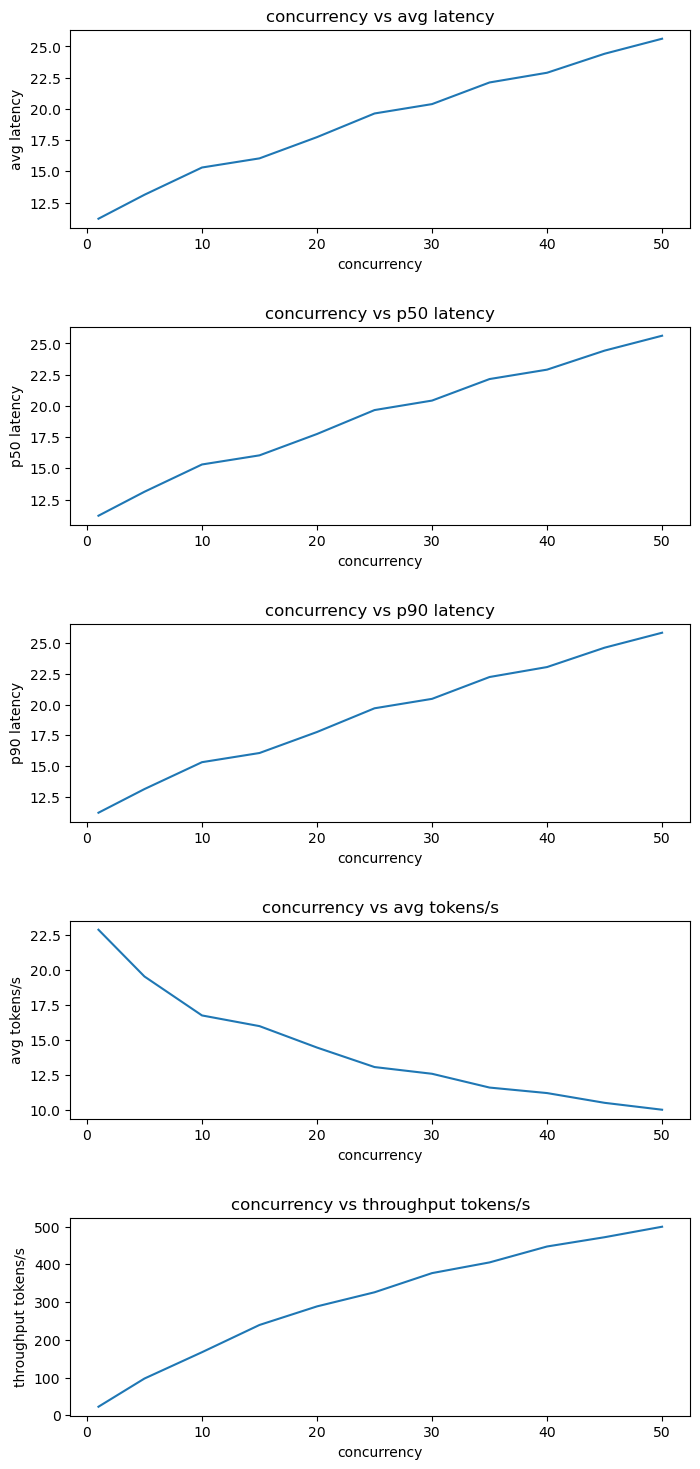

In [36]:
# 创建图形
fig, axs = plt.subplots(5, 1, figsize=(8, 18))

# 绘制第avg timecost
axs[0].plot(x, y2)
axs[0].set_title('concurrency vs avg latency')
axs[0].set_xlabel('concurrency')
axs[0].set_ylabel('avg latency')

# 绘制第一列与第三列的关系
axs[1].plot(x, y3)
axs[1].set_title('concurrency vs p50 latency')
axs[1].set_xlabel('concurrency')
axs[1].set_ylabel('p50 latency')

# 绘制第一列与第四列的关系
axs[2].plot(x, y4)
axs[2].set_title('concurrency vs p90 latency')
axs[2].set_xlabel('concurrency')
axs[2].set_ylabel('p90 latency')

# 绘制第一列与第四列的关系
axs[3].plot(x, y5)
axs[3].set_title('concurrency vs avg tokens/s')
axs[3].set_xlabel('concurrency')
axs[3].set_ylabel('avg tokens/s')


# 绘制第一列与第四列的关系
axs[4].plot(x, y6)
axs[4].set_title('concurrency vs throughput tokens/s')
axs[4].set_xlabel('concurrency')
axs[4].set_ylabel('throughput tokens/s')

# 调整子图之间的间距
plt.subplots_adjust(hspace=0.5)

# 显示图形
plt.show()

## Clean up the environment

In [37]:
sess.delete_endpoint(endpoint_name)
sess.delete_endpoint_config(endpoint_name)
model.delete_model()